In [1]:
import pandas as pd
import numpy as np
import os 
import glob
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.cluster import KMeans
from sklearn.preprocessing import RobustScaler
import matplotlib.cm as cm
from sklearn.metrics import silhouette_samples, silhouette_score, pairwise_distances
from sklearn import metrics


import seaborn as sns

#a updated version of savvastj/nbashots used for kde shot plots had to update from 9 year old seaborn syntax
import shot_printer as sp

pd.set_option('display.max_rows', 2000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import warnings
warnings.filterwarnings('ignore')

#for shot ploting
import importlib
importlib.reload(sp)


<module 'shot_printer' from '/home/multivac/jupyter/Basketball/shot_printer.py'>

# Import and Clean data
data fetched from NBA API using methods in get_data.ipynb

In [255]:
#Dont Run me
#Convert year by year files to One big CSV
files = glob.glob(os.path.join('Data/byYear/',"*.csv"))
dataframes = {}

for file in files:
    file_name = os.path.basename(file)
    base_name = os.path.splitext(file_name)[0]
    df = pd.read_csv(file)
    dataframes[base_name] = df

box_data = pd.DataFrame()
advanced_box_data = pd.DataFrame()
play_by_play = pd.DataFrame()
play_type = pd.DataFrame()
playertracking_data = pd.DataFrame()
shotchart_data = pd.DataFrame()

for name, df in dataframes.items():
    if 'advanced_box_data' in name:
        advanced_box_data = pd.concat([advanced_box_data, df], ignore_index=True)
    elif 'box_data' in name:
        box_data = pd.concat([box_data, df], ignore_index=True)
    elif 'play_by_play' in name:
        play_by_play = pd.concat([play_by_play, df], ignore_index=True)
    elif 'play_type' in name:
        play_type = pd.concat([play_type, df], ignore_index=True)
    elif 'playertracking_data' in name:
        playertracking_data = pd.concat([playertracking_data, df], ignore_index=True)
    elif 'shotchart_data' in name:
        shotchart_data = pd.concat([shotchart_data, df], ignore_index=True)

advanced_box_data.to_csv(data_path +'player_advanced_box_data_13_to_24.csv')
box_data.to_csv(data_path + 'player_box_data_13_to_24.csv')
playertracking_data.to_csv(data_path + 'playertracking_data_13_to_24.csv')
shotchart_data.to_csv(data_path + 'player_shotchart_data_13_to_24.csv')

#player_advanced_box_data.to_csv(data_path + 'player_advanced_box_data_13_to_24.csv')

In [2]:
data_path = 'Data/'

In [3]:
#input dataframes

player_box_data= pd.read_csv(data_path + 'player_box_data_13_to_24.csv')
player_tracking_data= pd.read_csv(data_path + 'playertracking_data_13_to_24.csv')
player_shotchart_data = pd.read_csv(data_path + 'player_shotchart_data_13_to_24.csv')
player_advanced_box_data = pd.read_csv(data_path + 'player_advanced_box_data_13_to_24.csv')

team_game_adv_stats = pd.read_csv(data_path + 'team_advanced_stats_per_game_2013_to_2024.csv')
team_game_stats = pd.read_csv(data_path + 'nba_team_game_logs_2013_to_2024.csv')
player_game_stats = pd.read_csv(data_path + 'nba_player_game_logs_2013_to_2024.csv')

#have data not using
#player_play_by_play = pd.read_csv(data_path + 'player_play_by_play_data_23_to_24.csv')
#player_play_type = pd.read_csv(data_path + 'player_play_type_data_23_to_24.csv')

In [59]:
player_shotchart_data['SHOT_ZONE_RANGE'].unique()

array(['Less Than 8 ft.', '16-24 ft.', '24+ ft.', '8-16 ft.',
       'Back Court Shot'], dtype=object)

In [57]:
player_shotchart_data

Unnamed: 0          GRID_TYPE   GAME_ID  GAME_EVENT_ID  PLAYER_ID       PLAYER_NAME     TEAM_ID            TEAM_NAME  PERIOD  MINUTES_REMAINING  SECONDS_REMAINING   EVENT_TYPE                     ACTION_TYPE       SHOT_TYPE        SHOT_ZONE_BASIC         SHOT_ZONE_AREA  SHOT_ZONE_RANGE  SHOT_DISTANCE  LOC_X  LOC_Y  SHOT_ATTEMPTED_FLAG  SHOT_MADE_FLAG  GAME_DATE  HTM  VTM
0                 0  Shot Chart Detail  21300002              3       2617     Udonis Haslem  1610612748           Miami Heat       1                 11                 43    Made Shot                       Dunk Shot  2PT Field Goal        Restricted Area              Center(C)  Less Than 8 ft.              0      2      3                    1               1   20131029  MIA  CHI
1                 1  Shot Chart Detail  21300002              4     202710      Jimmy Butler  1610612741        Chicago Bulls       1                 11                 17  Missed Shot                       Jump Shot  2PT Field Goal              Mid-Range   Left Side Center(LC)        16-24 ft.             21   -134    164                    1               0   20131029  MIA  CHI
2                 2  Shot Chart Detail  21300002              6       2548       Dwyane Wade  1610612748           Miami Heat       1                 11                 10  Missed Shot                       Jump Shot  2PT Field Goal              Mid-Range          Right Side(R)        16-24 ft.             20    181    101                    1               0   20131029  MIA  CHI
3                 3  Shot Chart Detail  21300002              9       2547        Chris Bosh  1610612748           Miami Heat       1                 10                 37  Missed Shot                       Jump Shot  3PT Field Goal      Above the Break 3  Right Side Center(RC)          24+ ft.             25    226    127                    1               0   20131029  MIA  CHI
4                 4  Shot Chart Detail  21300002             11     201565      Derrick Rose  1610612741        Chicago Bulls       1                 10                 22    Made Shot              Driving Layup Shot  2PT Field Goal        Restricted Area              Center(C)  Less Than 8 ft.              1      6      9                    1               1   20131029  MIA  CHI
...             ...                ...       ...            ...        ...               ...         ...                  ...     ...                ...                ...          ...                             ...             ...                    ...                    ...              ...            ...    ...    ...                  ...             ...        ...  ...  ...
2289862     2289862  Shot Chart Detail  22301187            581    1630550           JT Thor  1610612766    Charlotte Hornets       4                  1                 29  Missed Shot             Step Back Jump shot  3PT Field Goal      Above the Break 3              Center(C)          24+ ft.             25    -15    251                    1               0   20240414  CLE  CHA
2289863     2289863  Shot Chart Detail  22301187            583    1641734       Emoni Bates  1610612739  Cleveland Cavaliers       4                  1                 20  Missed Shot  Running Finger Roll Layup Shot  2PT Field Goal        Restricted Area              Center(C)  Less Than 8 ft.              1      1     15                    1               0   20240414  CLE  CHA
2289864     2289864  Shot Chart Detail  22301187            586     202684  Tristan Thompson  1610612739  Cleveland Cavaliers       4                  1                  6  Missed Shot               Driving Dunk Shot  2PT Field Goal        Restricted Area              Center(C)  Less Than 8 ft.              0      9      2                    1               0   20240414  CLE  CHA
2289865     2289865  Shot Chart Detail  22301187            589    1641733    Nick Smith Jr.  1610612766    Charlotte Hornets       4                  0                 46    Made

In [4]:
#columns with no data for all players
player_box_data.dropna(inplace=True,axis =1 )

# Create key columns
player_advanced_box_data['combined_key'] = player_advanced_box_data['gameId'].astype(str) + '_' + player_advanced_box_data['personId'].astype(str)
player_tracking_data['combined_key'] = player_tracking_data['gameId'].astype(str) + '_' + player_tracking_data['personId'].astype(str)
player_box_data['combined_key'] = player_box_data['gameId'].astype(str) + '_' + player_box_data['personId'].astype(str)

#merge on key drop duplcated columns 
#https://stackoverflow.com/questions/19125091/pandas-merge-how-to-avoid-duplicating-columns
big_box = player_advanced_box_data.merge(player_tracking_data, on='combined_key', how='outer', suffixes=('', '_y'))
big_box.drop(big_box.filter(regex='_y$').columns, axis=1, inplace=True)

big_box = big_box.merge(player_tracking_data, on='combined_key', how='outer', suffixes=('', '_y'))
big_box.drop(big_box.filter(regex='_y$').columns, axis=1, inplace=True)

big_box.drop(columns=['combined_key'],inplace=True)

#na values
    #position: non starters have no position data, Drop will make our own
    #comment: only rows with values are for did not play coaches dcision or Injury, and na 
    #jerseyNum: not a single value, Drop no value
    #minutes: inverse of comment collumn, fill zeros

big_box = big_box.drop(columns=['jerseyNum','Unnamed: 0','GAME_ID'])
big_box.fillna({'minutes' : '00:00', 'position' : 'n','comment' : 'none'},inplace=True)

#dont know why 3 rows of nan
big_box.dropna(inplace=True,axis=0)


df_team_stats = team_game_stats.merge(team_game_adv_stats, on=['GAME_ID', 'TEAM_ID'], how='inner')
# W to 1 and L to 0
df_team_stats['WL'] = df_team_stats['WL'].apply(lambda x: 1 if x == 'W' else 0)

# removes "Rank" columns
df_team_stats = df_team_stats.drop(columns=[col for col in df_team_stats.columns if col.endswith('RANK')])

#rebounds
null_or_zero_oreb_pct = df_team_stats[(df_team_stats['OREB_PCT'].isnull()) | (df_team_stats['OREB_PCT'] == 0)]

#find rows with absolutely no reb data
no_rebounding_data = df_team_stats[
    (df_team_stats['OREB_PCT'].isnull() | (df_team_stats['OREB_PCT'] == 0)) &
    (df_team_stats['DREB_PCT'].isnull() | (df_team_stats['DREB_PCT'] == 0)) &
    (df_team_stats['REB_PCT'].isnull() | (df_team_stats['REB_PCT'] == 0))
]

#Home Away 
df_team_stats['HOME_AWAY'] = df_team_stats['MATCHUP'].apply(lambda x: 1 if 'vs' in x else 0)

# Create opponent statistics using the GAME_ID
df_team_stats['OppOREB'] = df_team_stats.groupby('GAME_ID')['OREB'].shift(-1)
df_team_stats['OppDREB'] = df_team_stats.groupby('GAME_ID')['DREB'].shift(-1)
df_team_stats['OppREB'] = df_team_stats.groupby('GAME_ID')['REB'].shift(-1)

# Apply the same logic in reverse for the other team in the same game
df_team_stats['OppOREB'].fillna(df_team_stats.groupby('GAME_ID')['OREB'].shift(1), inplace=True)
df_team_stats['OppDREB'].fillna(df_team_stats.groupby('GAME_ID')['DREB'].shift(1), inplace=True)
df_team_stats['OppREB'].fillna(df_team_stats.groupby('GAME_ID')['REB'].shift(1), inplace=True)

# fill missing OREB_PCT, DREB_PCT, and REB_PCT values using the rebounding formulas
df_team_stats['OREB_PCT'] = np.where(df_team_stats['OREB_PCT'].isnull(),
                                      df_team_stats['OREB'] / (df_team_stats['OREB'] + df_team_stats['OppDREB']),
                                      df_team_stats['OREB_PCT'])

df_team_stats['DREB_PCT'] = np.where(df_team_stats['DREB_PCT'].isnull(),
                                      df_team_stats['DREB'] / (df_team_stats['DREB'] + df_team_stats['OppOREB']),
                                      df_team_stats['DREB_PCT'])

df_team_stats['REB_PCT'] = np.where(df_team_stats['REB_PCT'].isnull(),
                                     df_team_stats['REB'] / (df_team_stats['REB'] + df_team_stats['OppREB']),
                                     df_team_stats['REB_PCT'])

#dropping available flag, usage %, and newly-created opp reb. Team usage % for a game is going to be 100%, so it's not useful data
df_team_stats = df_team_stats.drop(columns=['USG_PCT', 'AVAILABLE_FLAG','OppOREB','OppDREB','OppREB'])

#grab numerics 
df_team_numeric = df_team_stats.select_dtypes(include=['float64', 'int64'])

In [82]:

print("Num Games ")
print( "team game stats:", len(set(team_game_stats['GAME_ID'])))
print( "team game advanced stats:", len(set(team_game_adv_stats['GAME_ID'])))
print( "player game  stats:", len(set(player_game_stats['GAME_ID'])))
print("----------------------------")
print("kaden combined Player stats:",len(set(big_box['gameId'])))

Num Games 
team game stats: 13209
team game advanced stats: 13190
player game  stats: 13209
----------------------------
kaden combined Player stats: 13209


# rolling setup

In [169]:
def apply_rolling_average_within_season(df, columns_to_roll, window=5):
    df = df.sort_values(by=['TEAM_ID', 'SEASON_YEAR', 'GAME_DATE'])
    for col in columns_to_roll:
        df[col + '_rolling'] = df.groupby(['TEAM_ID', 'SEASON_YEAR'])[col].rolling(window=window, min_periods=1).apply(lambda x: x[:-1].mean() if len(x) > 1 else np.nan).reset_index(level=[0,1], drop=True)
    return df

columns_to_roll = ['FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST',
                   'TOV', 'STL', 'BLK', 'BLKA', 'PF', 'PFD', 'PTS', 'PLUS_MINUS', 'E_OFF_RATING', 'OFF_RATING',
                   'E_DEF_RATING', 'DEF_RATING', 'E_NET_RATING', 'NET_RATING', 'AST_PCT', 'AST_TOV', 'AST_RATIO',
                   'E_TM_TOV_PCT', 'TM_TOV_PCT', 'EFG_PCT', 'TS_PCT', 'E_USG_PCT', 'E_PACE', 'PACE',
                   'PACE_PER40', 'POSS', 'PIE']

df_team_stats_rolling = apply_rolling_average_within_season(df_team_stats, columns_to_roll, window=5)

In [396]:
df_team_stats_rolling

SEASON_YEAR     TEAM_ID TEAM_ABBREVIATION_x        TEAM_NAME_x   GAME_ID            GAME_DATE      MATCHUP  WL  MIN_x  FGM  FGA  FG_PCT  FG3M  FG3A  FG3_PCT  FTM  FTA  FT_PCT  OREB  DREB  REB  AST   TOV  STL  BLK  BLKA  PF  PFD  PTS  PLUS_MINUS   Season TEAM_NAME_y TEAM_ABBREVIATION_y  TEAM_CITY          MIN_y  E_OFF_RATING  OFF_RATING  E_DEF_RATING  DEF_RATING  E_NET_RATING  NET_RATING  AST_PCT  AST_TOV  AST_RATIO  OREB_PCT  DREB_PCT   REB_PCT  E_TM_TOV_PCT  TM_TOV_PCT  EFG_PCT  TS_PCT  E_USG_PCT  E_PACE   PACE  PACE_PER40  POSS    PIE  HOME_AWAY  FGM_rolling  FGA_rolling  FG_PCT_rolling  FG3M_rolling  FG3A_rolling  FG3_PCT_rolling  FTM_rolling  FTA_rolling  FT_PCT_rolling  OREB_rolling  DREB_rolling  REB_rolling  AST_rolling  TOV_rolling  STL_rolling  BLK_rolling  BLKA_rolling  PF_rolling  PFD_rolling  PTS_rolling  PLUS_MINUS_rolling  E_OFF_RATING_rolling  OFF_RATING_rolling  E_DEF_RATING_rolling  DEF_RATING_rolling  E_NET_RATING_rolling  NET_RATING_rolling  AST_PCT_rolling  \
2429      2013-14  1610612737                 ATL      Atlanta Hawks  21300012  2013-10-30T00:00:00    ATL @ DAL   0   48.0   37   76   0.487     8    24    0.333   27   35   0.771     5    28   33   27  17.0   16    5     2  20   22  109        -9.0  2013-14       Hawks                 ATL    Atlanta  240.000000:00         105.4       104.8         117.3       114.6         -11.9        -9.8    0.730     1.59       19.9  0.182000     0.800  0.440000        16.441        16.3    0.539   0.596      0.201  101.98  103.5       86.25   104  0.467          0          NaN          NaN             NaN           NaN           NaN              NaN          NaN          NaN             NaN           NaN           NaN          NaN          NaN          NaN          NaN          NaN           NaN         NaN          NaN          NaN                 NaN                   NaN                 NaN                   NaN                 NaN                   NaN                 NaN              NaN   
2408      2013-14  1610612737                 ATL      Atlanta Hawks  21300023  2013-11-01T00:00:00  ATL vs. TOR   1   48.0   36   77   0.468    10    23    0.435   20   31   0.645     7    30   37   24  13.0    7    3     6  12   25  102         7.0  2013-14       Hawks                 ATL    Atlanta  240.000000:00         105.5       107.4          98.8       100.0           6.8         7.4    0.667     1.85       18.8  0.234000     0.720  0.485000        13.452        13.7    0.532   0.563      0.201   96.40   95.0       79.17    95  0.587          1    37.000000        76.00        0.487000          8.00         24.00         0.333000    27.000000    35.000000        0.771000      5.000000     28.000000    33.000000    27.000000    17.000000    16.000000     5.000000          2.00       20.00    22.000000   109.000000           -9.000000            105.400000          104.800000            117.300000          114.600000            -11.900000           -9.800000         0.730000   
2379      2013-14  1610612737                 ATL      Atlanta Hawks  21300046  2013-11-03T00:00:00    ATL @ LAL   0   48.0   40   90   0.444     9    22    0.409   14   26   0.538    10    42   52   26  13.0    9    3     7  22   24  103        -2.0  2013-14       Hawks                 ATL    Atlanta  240.000000:00          98.6        97.2          98.5       100.0           0.1        -2.8    0.650     2.00       18.5  0.175439     0.830  0.495238        12.447        12.3    0.494   0.508      0.197  105.50  105.5       87.92   106  0.476          0    36.500000        76.50        0.477500          9.00         23.50         0.384000    23.500000    33.000000        0.708000      6.000000     29.000000    35.000000    25.500000    15.000000    11.500000     4.000000          4.00       16.00    23.500000   105.500000           -1.000000            105.450000          106.100000            108.050000          107.300000             -2.550000           -1.200000         0.698500   
2358  

In [5]:
# function to produce per season clustering 
def cluster4000(df,shot_df):
    #remove the fluf
    df.drop([ 'teamId', 'teamCity', 'teamName', 'teamTricode', 'teamSlug','firstName','possessions', #'gameId',
                                'familyName', 'nameI'],axis=1,inplace =True)
    df.drop(df.filter(like='estimated').columns, axis=1,inplace = True)

    #get players  
    player_set = set(df['personId'])

    #convert time to seconds 
    #https://stackoverflow.com/questions/63663747/pandas-convert-time-into-seconds-for-all-values-in-column
    df['minutes']=df['minutes'].apply(lambda x: float(x.split(':')[0])*60+float(x.split(':')[1]))

    #get season averages 
    df_player = df.groupby('personId').mean(numeric_only=True).reset_index()
    
    #add average play time and % starting 5 
    for player in player_set:
        try:
            avg_play_time = df[df['personId'] == player]['minutes'].sum() / len(df[df['personId'] == player]) /60 
        except:
            avg_play_time = 0
        df.loc[df['personId'] == player, 'min_per_game'] = avg_play_time
        try:
            starter_pct = sum(df[df['personId'] == player]['position'] != 'n') / len(df[df['personId'] == player])
        except:
            starter_pct = 0 
        df.loc[df['personId'] == player, 'pct_games_started'] = starter_pct

    ######adding player shot location data 

    shot_chart_num = shot_df.drop([
        'GRID_TYPE', 'GAME_ID', 'GAME_EVENT_ID', 'PLAYER_NAME', 'TEAM_ID', 'TEAM_NAME',
        'PERIOD', 'ACTION_TYPE', 'SHOT_TYPE', 'MINUTES_REMAINING', 'EVENT_TYPE',
        'SECONDS_REMAINING', 'GAME_DATE', 'HTM', 'VTM', 'LOC_X', 'LOC_Y', 'SHOT_DISTANCE'
    ], axis=1)

    player_shot_summaries = pd.DataFrame()

    # calculate shooting stats for different zones
    for player_id, player_df in shot_chart_num.groupby('PLAYER_ID'):
       
        zone_summary = player_df.groupby(['SHOT_ZONE_BASIC']).agg(
            shot_attempts=('SHOT_ATTEMPTED_FLAG', 'size'),
            made_shots=('SHOT_MADE_FLAG', 'sum')
        ).reset_index()
    
        zone_summary['shooting_frequency'] = zone_summary['shot_attempts'] / zone_summary['shot_attempts'].sum()
        zone_summary['shooting_percentage'] = zone_summary['made_shots'] / zone_summary['shot_attempts']
    
        # Add player ID and clean up columns
        zone_summary['PLAYER_ID'] = player_id
        zone_summary['Location'] = zone_summary['SHOT_ZONE_BASIC']
        zone_summary = zone_summary.drop(['shot_attempts', 'made_shots', 'SHOT_ZONE_BASIC'], axis=1)
    
        # Pivot and flatten columns
        pivot_table = zone_summary.pivot_table(
            index='PLAYER_ID',
            columns='Location',
            values=['shooting_frequency', 'shooting_percentage'],
            aggfunc='first'
        )
        pivot_table.columns = [f'{stat}_{location}'.replace(' ', '_') for stat, location in pivot_table.columns]
        pivot_table.reset_index(inplace=True)
    
    
        player_shot_summaries = pd.concat([player_shot_summaries, pivot_table], ignore_index=True)
    
    # Merge with the box23_24_player DataFrame
    df_player_shots = df_player.merge(player_shot_summaries, left_on='personId', right_on='PLAYER_ID', how='outer',suffixes=('', '_y'))

    # Fill NaN values with 0 for people with no shots or missing shot positions
    df_player_shots = df_player_shots.fillna(0)

    #data's ready drop the ID's and scale
    to_cluster = df_player_shots.drop(['PLAYER_ID','personId'],axis = 1)

    scaled_box = RobustScaler().fit_transform(to_cluster)
    #input
    X = scaled_box
    
    clusterer = KMeans(n_clusters=14, random_state=42, n_init=100, init='k-means++')
    cluster_labels = clusterer.fit_predict(X)
    results = pd.DataFrame(df_player['personId'])
    results['cluster'] = cluster_labels

    results_id = results[['personId','cluster']]
    cluster_shots = results_id.merge(df_player_shots, on='personId', how='outer')
    cluster_shots.drop(['PLAYER_ID'], inplace = True,axis = 1)

    return cluster_shots

In [133]:
#make a dictonary of games in each season 
season_prefixs = ['213','214','215','216','217','218','219','220','221','222','223']
games = list(set(map(str, big_box['gameId'])))
season_game_dict = {}

for s in season_prefixs: 
    season_games = [game for game in games if game.startswith(s)]
    season_games = [float(g) for g in season_games]
    season_game_dict[s] = season_games

For n_clusters = 13 The average silhouette_score is : 0.16651 caliniski harabasz score 83.29


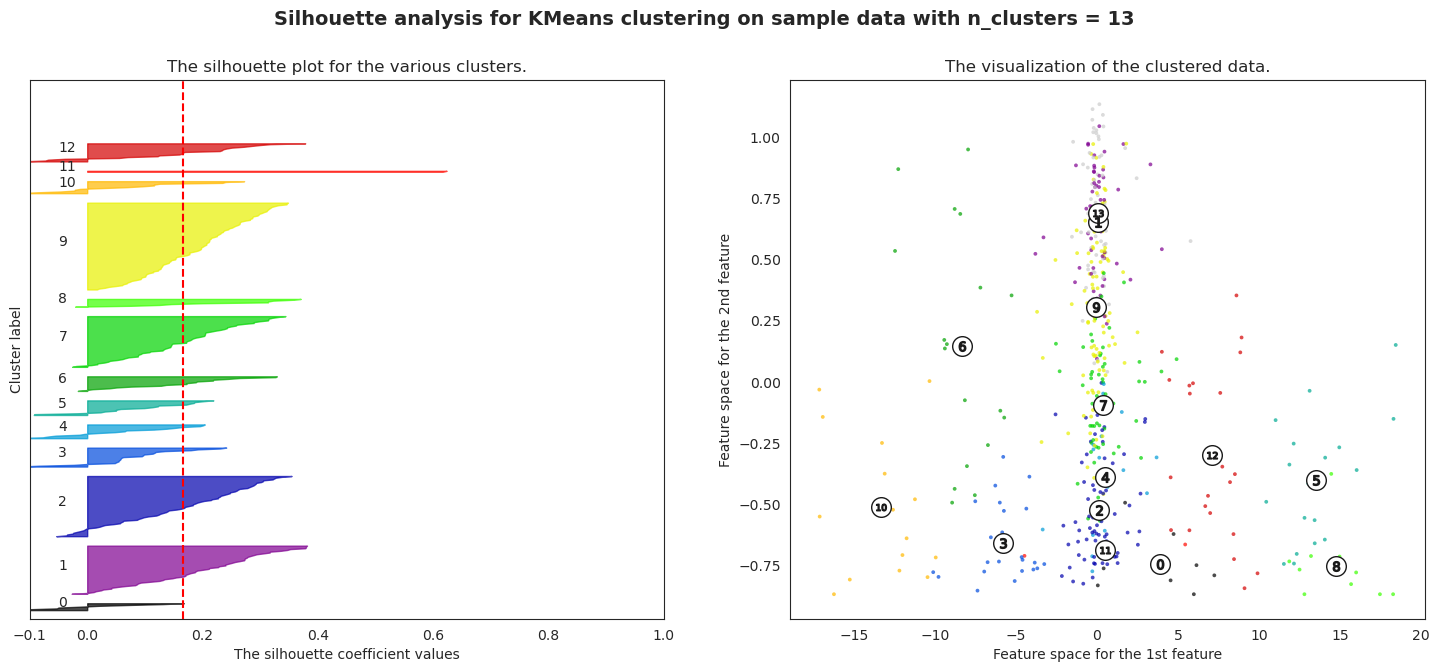

For n_clusters = 13 The average silhouette_score is : 0.12734 caliniski harabasz score 66.28


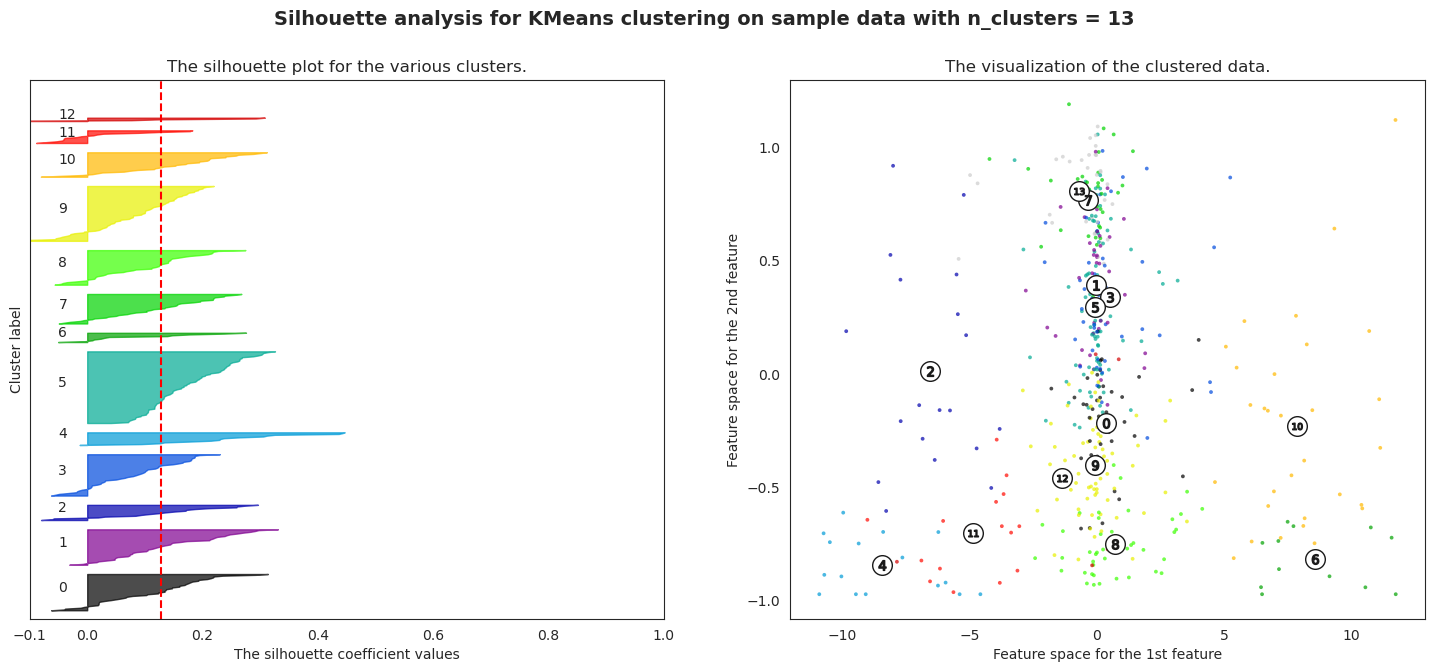

For n_clusters = 13 The average silhouette_score is : 0.15562 caliniski harabasz score 66.76


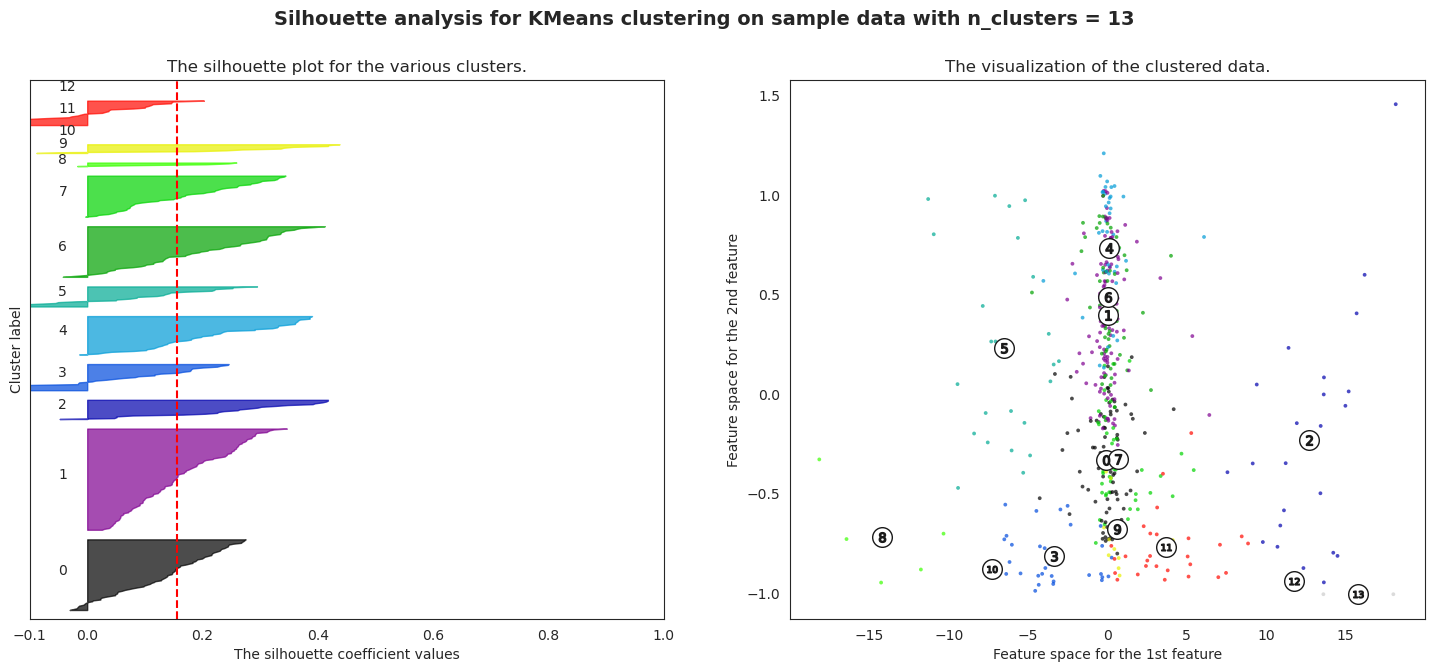

For n_clusters = 13 The average silhouette_score is : 0.12758 caliniski harabasz score 66.28


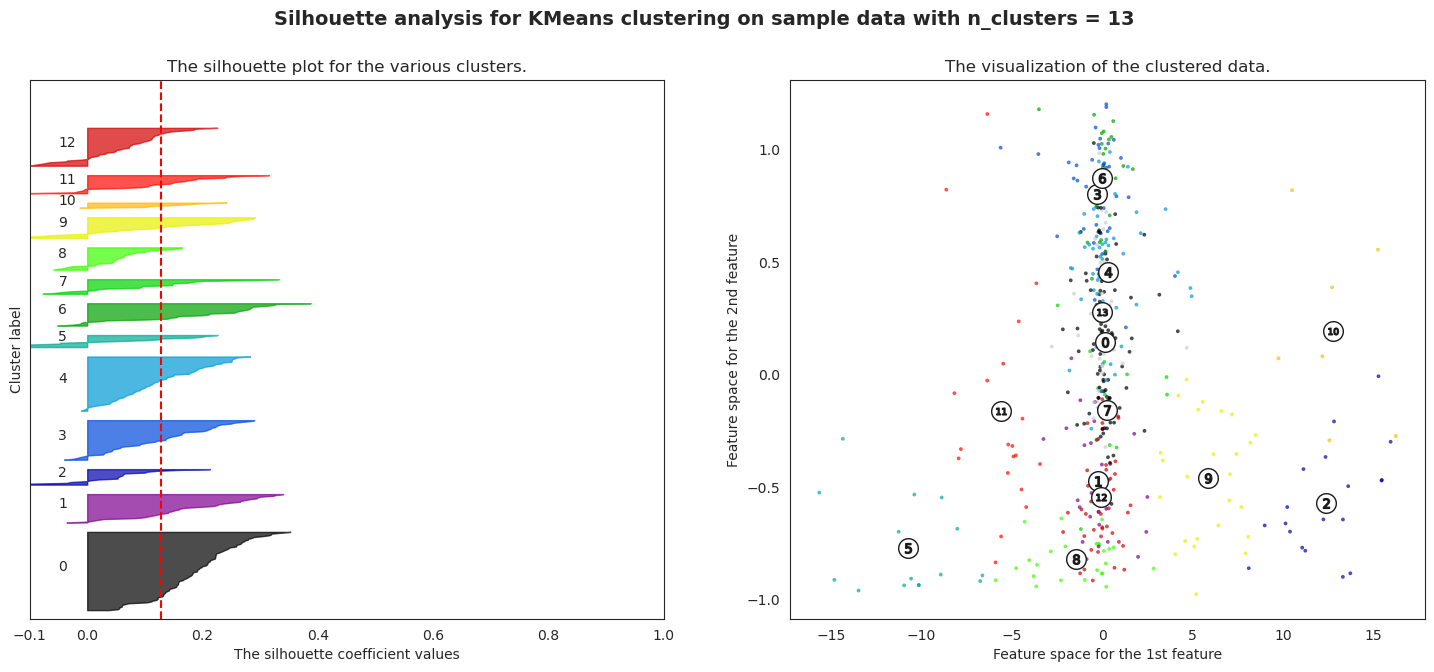

For n_clusters = 13 The average silhouette_score is : 0.12854 caliniski harabasz score 72.77


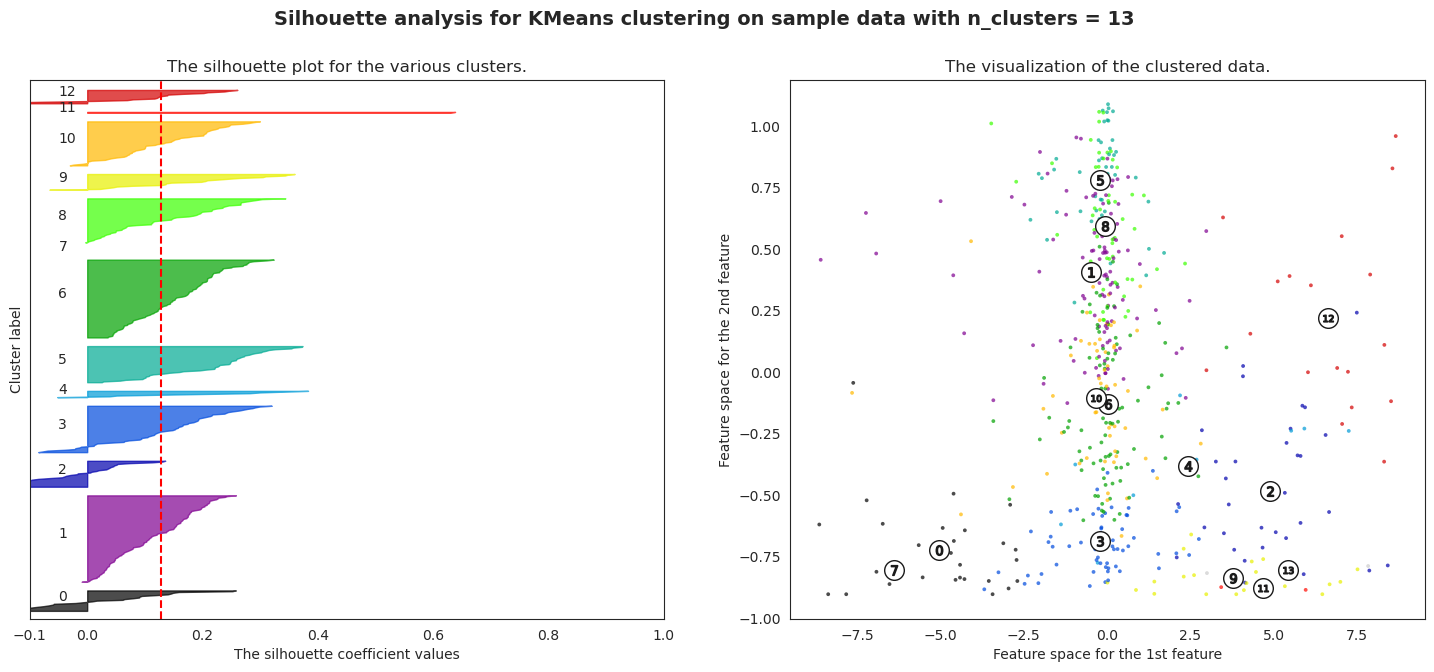

For n_clusters = 13 The average silhouette_score is : 0.12134 caliniski harabasz score 57.02


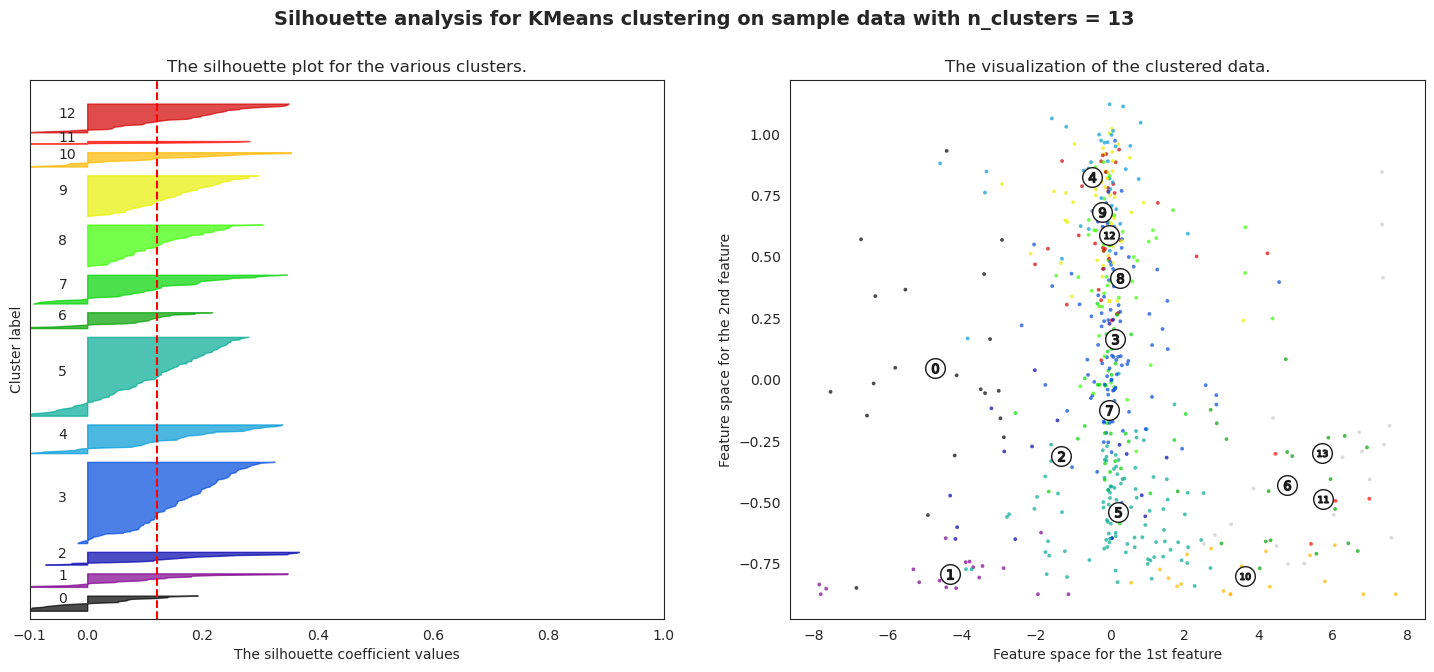

For n_clusters = 13 The average silhouette_score is : 0.11117 caliniski harabasz score 68.74


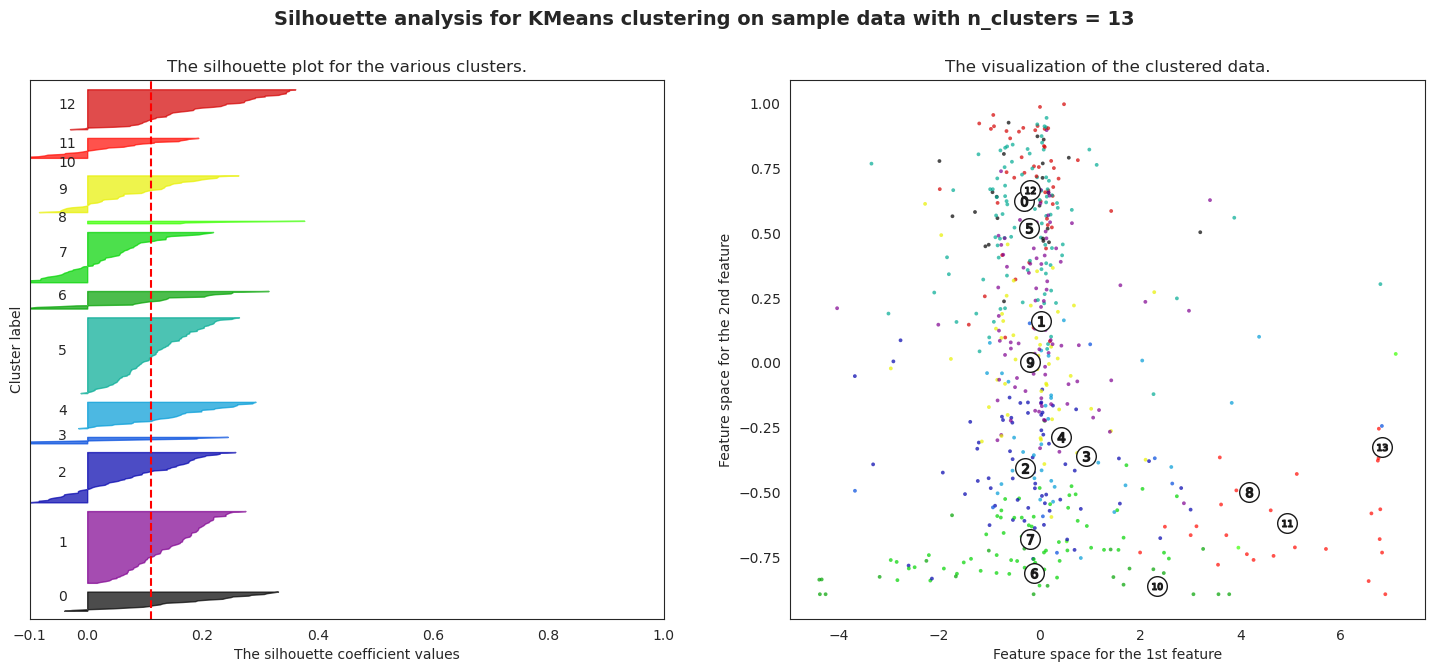

For n_clusters = 13 The average silhouette_score is : 0.1123 caliniski harabasz score 62.32


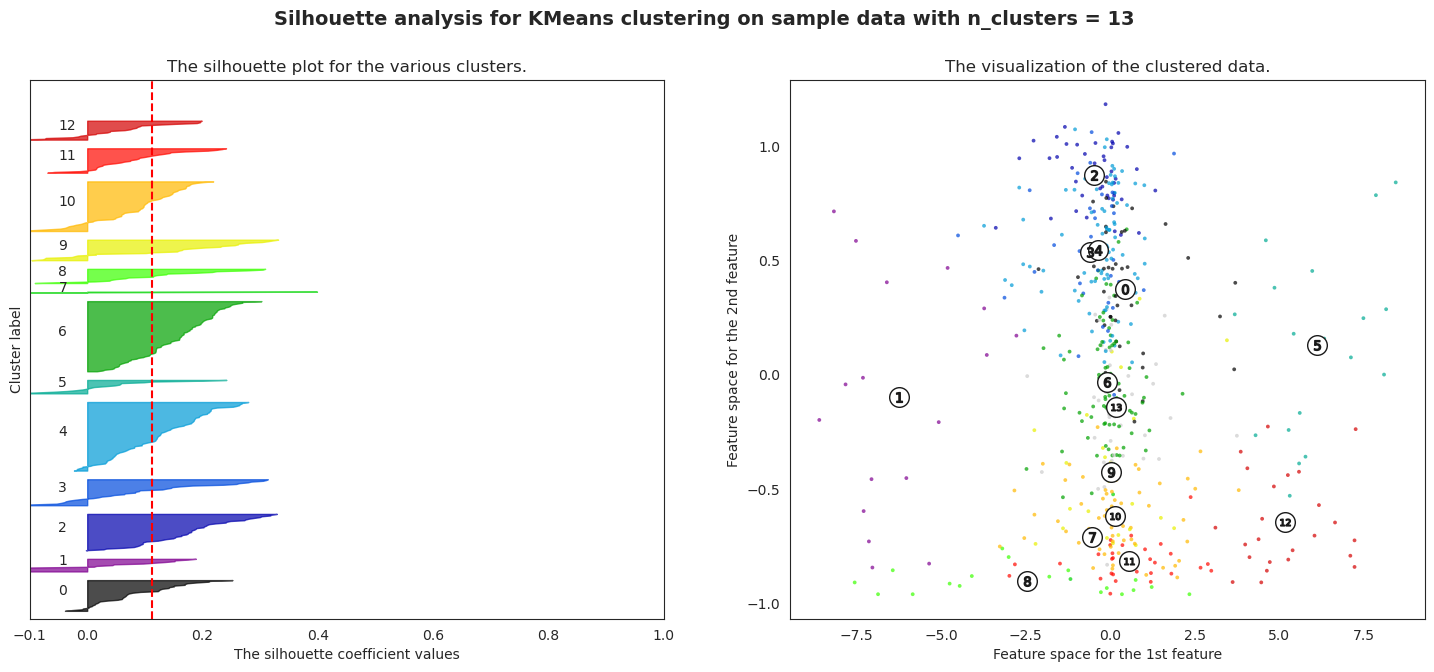

For n_clusters = 13 The average silhouette_score is : 0.11016 caliniski harabasz score 69.9


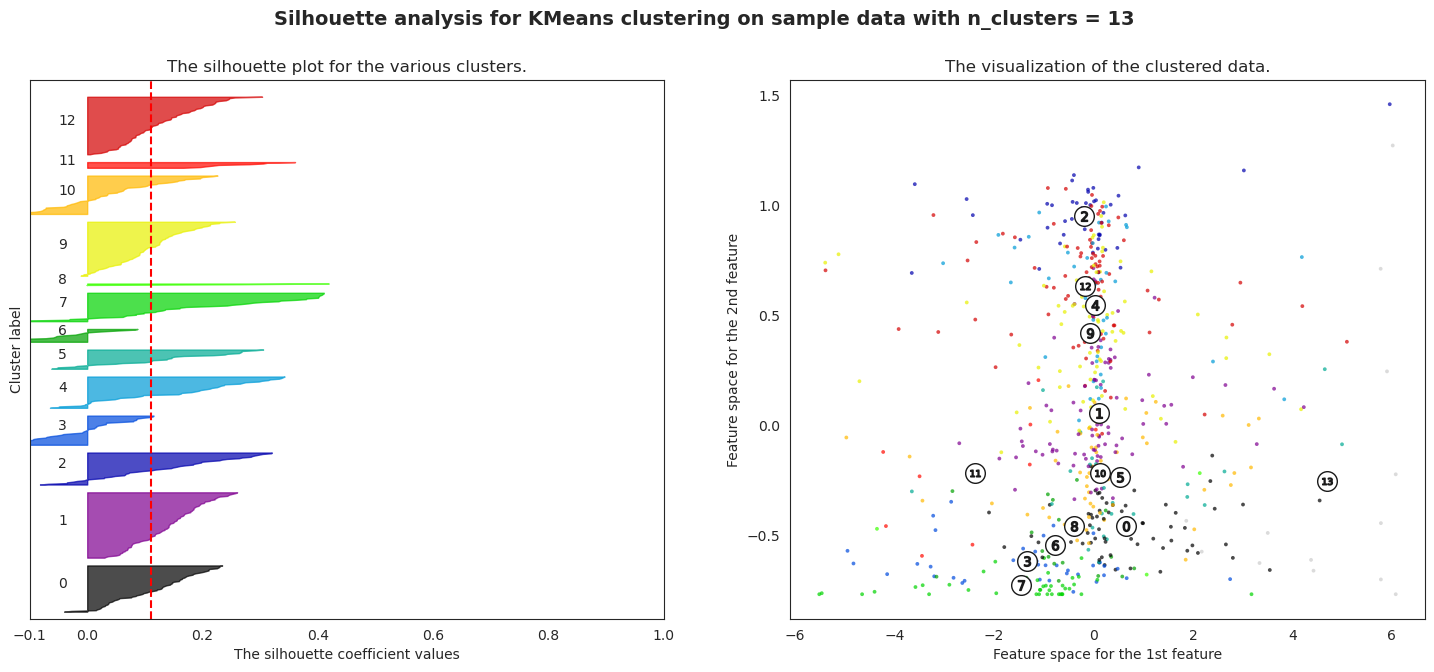

For n_clusters = 13 The average silhouette_score is : 0.14145 caliniski harabasz score 79.72


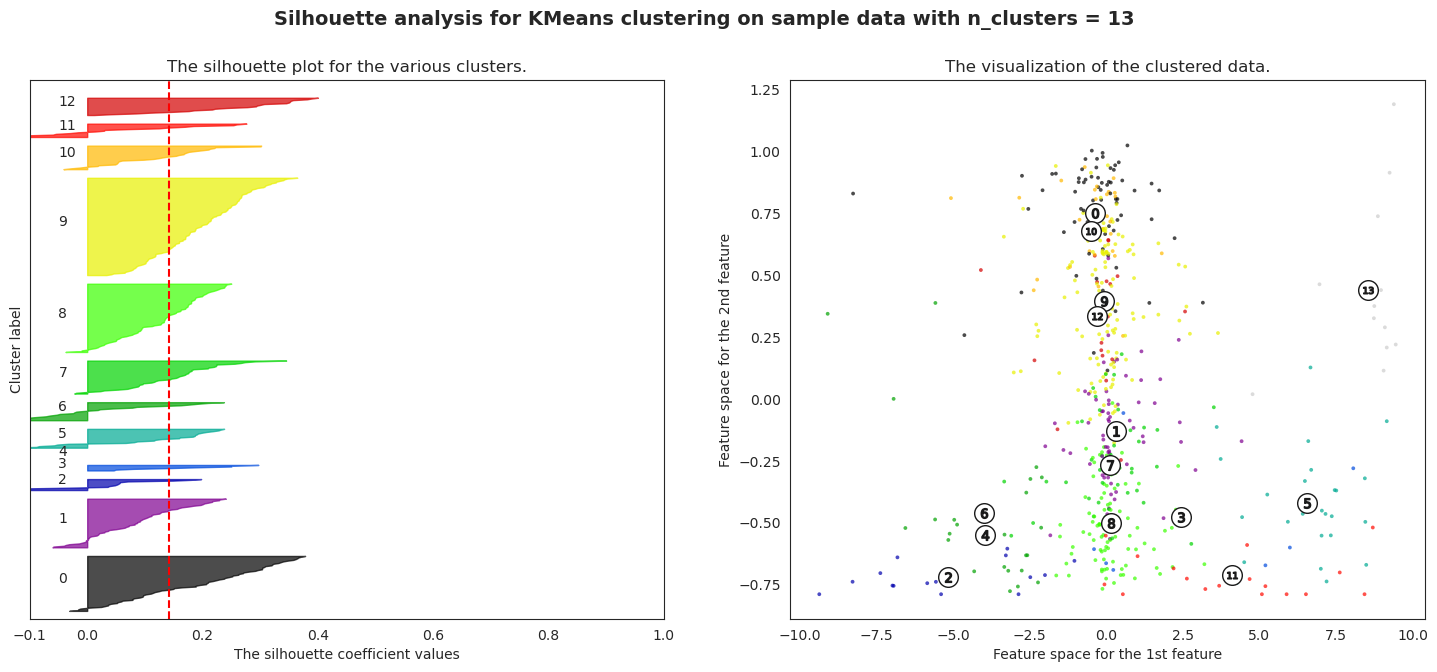

For n_clusters = 13 The average silhouette_score is : 0.12234 caliniski harabasz score 69.86


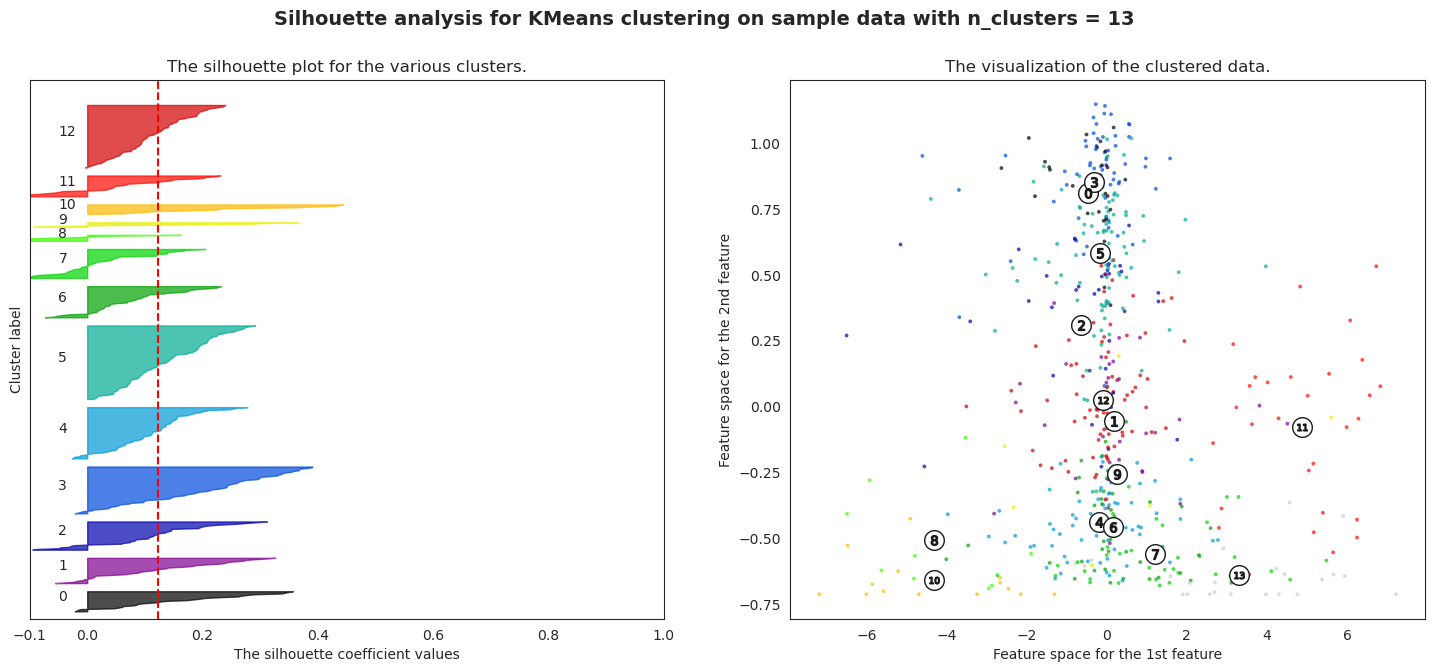

In [87]:
#make a dictonary of games in each season 
season_prefixs = ['213','214','215','216','217','218','219','220','221','222','223']
games = list(set(map(str, big_box['gameId'])))
season_game_dict = {}


columns_to_roll = ['FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST',
                   'TOV', 'STL', 'BLK', 'BLKA', 'PF', 'PFD', 'PTS', 'PLUS_MINUS', 'E_OFF_RATING', 'OFF_RATING',
                   'E_DEF_RATING', 'DEF_RATING', 'E_NET_RATING', 'NET_RATING', 'AST_PCT', 'AST_TOV', 'AST_RATIO',
                   'E_TM_TOV_PCT', 'TM_TOV_PCT', 'EFG_PCT', 'TS_PCT', 'E_USG_PCT', 'E_PACE', 'PACE',
                   'PACE_PER40', 'POSS', 'PIE']
        #produce output dataframe and calculate rolling team statistics
        #output = team_data.copy()
        #for col in columns_to_roll:
        #    output[col + '_rolling'] = output[col].rolling(window=5, min_periods=1).apply(lambda x: x[:-1].mean() if len(x) > 1 else np.nan)


for s in season_prefixs: 
    season_games = [game for game in games if game.startswith(s)]
    season_games = [float(g) for g in season_games]
    season_game_dict[s] = season_games
#iterate though season
season_cluster_dict = {}
season_shot_dict = {}
season_team_data_dict = {}
for s in season_game_dict:
    games = season_game_dict[s]
    #get seasons data
    season_big_box = big_box[big_box['gameId'].isin(games)]
    season_team_game_stats = team_game_stats[team_game_stats['GAME_ID'].isin(games)]
    season_shot_chart = player_shotchart_data[player_shotchart_data['GAME_ID'].isin(games)]
    season_shot_dict[s] = season_shot_chart
    cluster_big_box = season_big_box.copy()
    cluster = cluster4000plot(cluster_big_box,season_shot_chart,s)
    season_cluster_dict[s] = cluster
    team_data_dict = {}
    #work through each team
    for teamId in big_box['teamId'].unique():
        #get data for individual and team, sort team data chronological 
        team_data = season_team_game_stats[season_team_game_stats['TEAM_ID'] == teamId]
        team_data.sort_values(by=['TEAM_ID', 'SEASON_YEAR', 'GAME_DATE'],inplace=True )
        player_data = season_big_box[season_big_box['teamId']==teamId]

        team_data['rolling_games'] = [
            team_data['GAME_ID'][max(0, i-5):i].tolist() for i in range(len(team_data))
        ]
       

In [ ]:
 
for  prev_games in team_data['rolling_games']:
    if not prev_games:  # Skip if the list is empty
        continue
    all_players_stats = []
    for game in prev_games:
        players = player_data[player_data['gameId']== game]
        all_players_stats.append(players[['personId','usagePercentage']])
    if all_players_stats:
        window_players_stats = pd.concat(all_players_stats, ignore_index=True)
        window_players_stats = window_players_stats.merge(cluster[['personId','cluster']], on='personId')
    
        grouped_stats = window_players_stats.groupby('cluster', as_index=False)['usagePercentage'].sum()
        pivoted_stats = grouped_stats.reset_index().pivot_table(index=grouped_stats.index, columns='cluster', values='usagePercentage', aggfunc='sum')
        
        pivoted_stats.columns = [f'cluster_{col}' for col in pivoted_stats.columns]
        all_clusters = [f'cluster_{i}' for i in range(14)]
        for cluster in all_clusters:
            if cluster not in pivoted_stats.columns:
                pivoted_stats[cluster] = 0

            team_data[cluster] = 0
            
        pivoted_stats = pivoted_stats[sorted(pivoted_stats.columns, key=lambda x: int(x.split('_')[1]))]
        summed_stats = pivoted_stats.sum().to_frame().T
        #
        summed_stats = pd.DataFrame(summed_stats, index=[0])
        
        #team_data.loc[idx, summed_stats.columns] = summed_stats.iloc[0]

team_data_dict[teamId] = team_data


season_team_data_dict[s] = team_data_dict

In [ ]:
len(cluster)
cluster

In [406]:
window_players_stats.merge(cluster[['personId','cluster']], on='personId',how= 'inner')

personId  minutes_numeric  cluster
0      101108.0        34.216667        0
1     1626172.0        27.966667       13
2     1627780.0        21.666667        3
3     1630228.0        20.133333       12
4     1630541.0        17.983333        3
...         ...              ...      ...
5133  1631311.0        17.283333       10
5134  1641764.0        21.450000       12
5135   202691.0        19.533333       12
5136   203952.0        20.216667       12
5137   203967.0        12.650000        3

[5138 rows x 3 columns]

# EDA

In [10]:
box23_24_player

personId      minutes  offensiveRating  defensiveRating  netRating  assistPercentage  assistToTurnover  assistRatio  offensiveReboundPercentage  defensiveReboundPercentage  reboundPercentage  turnoverRatio  effectiveFieldGoalPercentage  trueShootingPercentage  usagePercentage        pace  pacePer40       PIE     speed  distance  reboundChancesOffensive  reboundChancesDefensive  reboundChancesTotal    touches  secondaryAssists  freeThrowAssists     passes   assists  contestedFieldGoalsMade  contestedFieldGoalsAttempted  contestedFieldGoalPercentage  uncontestedFieldGoalsMade  uncontestedFieldGoalsAttempted  uncontestedFieldGoalsPercentage  fieldGoalPercentage  defendedAtRimFieldGoalsMade  defendedAtRimFieldGoalsAttempted  defendedAtRimFieldGoalPercentage  fieldGoalsMade  fieldGoalsAttempted  fieldGoalsPercentage  threePointersMade  threePointersAttempted  threePointersPercentage  freeThrowsMade  freeThrowsAttempted  freeThrowsPercentage  reboundsOffensive  reboundsDefensive  \
0        2544  2057.849315       114.590411       110.236986   4.357534          0.351699          2.783973    25.268493                    0.024562                    0.167205           0.101082      10.484932                      0.586110                0.615630         0.277356   98.828493  82.356986  0.166411  3.536712  2.190411                 2.095890                 8.602740            10.465753  73.767123          0.821918          0.698630  48.589041  8.068493                 4.068493                      6.917808                      0.551370                   5.027397                        9.986301                         0.488644             0.526959                     1.863014                          2.767123                          0.593151        9.383562            17.383562              0.527384           2.041096                4.972603                 0.393507        4.150685             5.534247              0.710836           0.835616           6.260274   
1      101108  1556.830508       111.442373       109.857627   1.572881          0.331898          3.516949    39.277966                    0.010966                    0.123407           0.068932       7.884746                      0.500644                0.521288         0.153576   97.889153  81.575085  0.112864  3.651017  1.730000                 0.966102                 5.847458             6.762712  56.762712          0.830508          0.508475  45.271186  6.661017                 0.491525                      1.237288                      0.288136                   2.932203                        6.525424                         0.410390             0.417610                     1.355932                          1.796610                          0.664966        3.491525             7.915254              0.417864           1.322034                3.559322                 0.326339        0.728814             0.881356              0.254644           0.305085           3.508475   
2      200768  1689.800000       111.021667       111.751667  -0.725000          0.211233          2.341667    34.895000                    0.020817                    0.097750           0.058283      11.443333                      0.538983                0.556883         0.125200   97.133833  80.945667  0.073533  3.766833  1.898333                 1.666667                 5.750000             7.333333  55.250000          0.400000          0.550000  45.716667  4.216667                 0.566667                      1.350000                      0.261383                   2.100000                        4.750000                         0.422767             0.409483                     1.933333                          2.466667                          0.676833        2.716667             6.283333              0.409717           1.633333                4.166667                 0.380950        1.050000             1.250000              0.381950           0.566667           2.666667   
3      200782   369.3

In [261]:
#change player slug formating to use as name in player_box dictinary of player box scores
big_box['playerSlug'] = big_box['playerSlug'].str.replace('-', '_', regex=False)

player_box = {}

for player in big_box['personId']:
    player_df = big_box[big_box['personId']== player]
    playerslug = player_df['playerSlug'].values[0]

    player_box[playerslug] = player_df
    

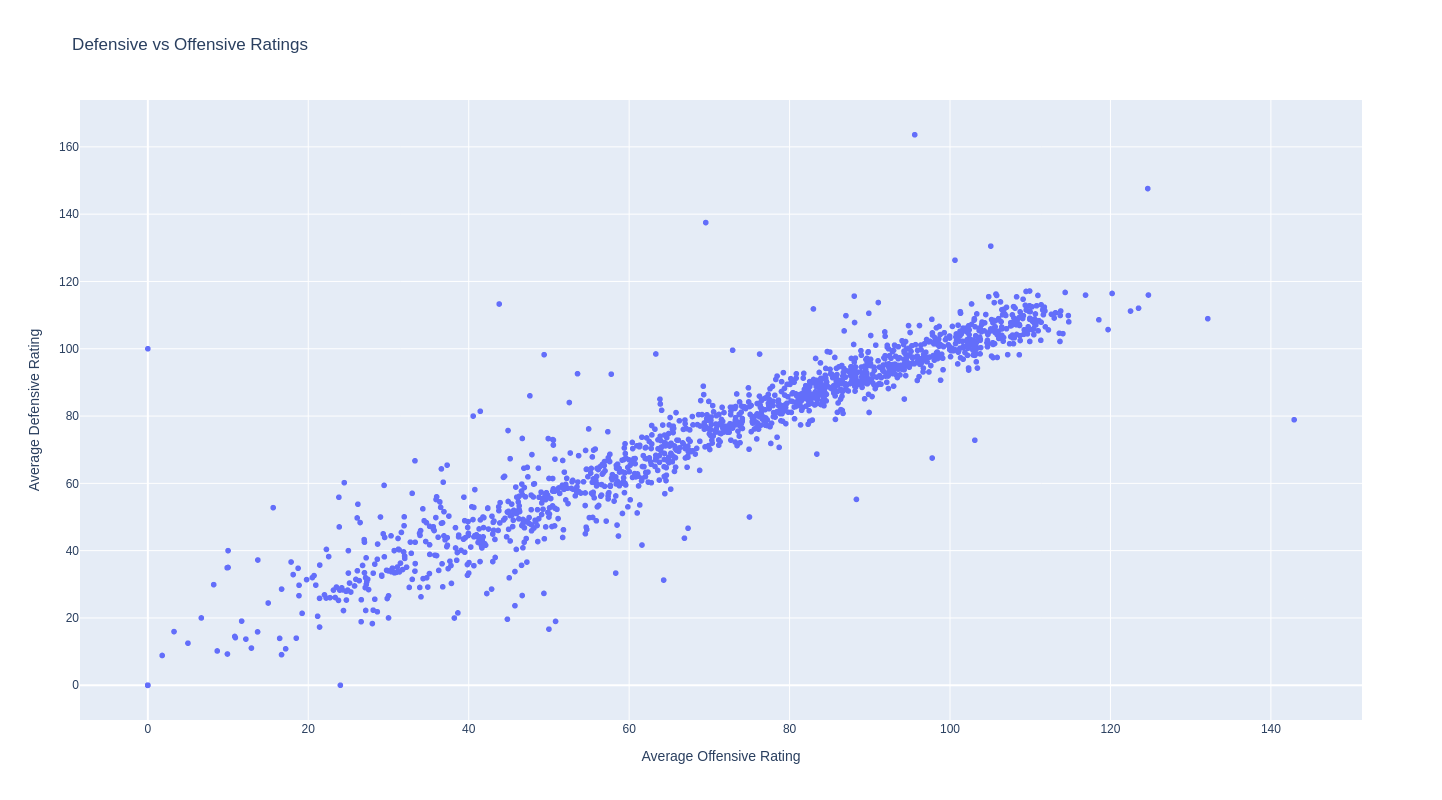

In [262]:
#first pretty picture
ratings_df = pd.DataFrame(columns=['Player', 'Average_Off_Rating', 'Average_Def_Rating'])

for player, df in player_box.items():
    avg_off_rating = df['offensiveRating'].mean()
    avg_def_rating = df['defensiveRating'].mean()
    player_df = pd.DataFrame({
        'Player': [player],
        'Average_Off_Rating': [avg_off_rating],
        'Average_Def_Rating': [avg_def_rating]
    })
    ratings_df = pd.concat([ratings_df, player_df], ignore_index=True)


fig = px.scatter(
    ratings_df,
    x='Average_Off_Rating',
    y='Average_Def_Rating',
    title='Defensive vs Offensive Ratings of Each Player',
    labels={'Average_Off_Rating': 'Average Offensive Rating', 'Average_Def_Rating': 'Average Defensive Rating'}
)

# Update traces to customize hover labels GPT
fig.update_traces(
    hovertemplate='<b>%{text}</b><br>Offensive Rating: %{x}<br>Defensive Rating: %{y}<extra></extra>',
    text=ratings_df['Player'],
    mode='markers'  
)

# Ulayout 
fig.update_layout(
    xaxis_title='Average Offensive Rating',
    yaxis_title='Average Defensive Rating',
    title='Defensive vs Offensive Ratings',
    hovermode='closest',
    width=800, 
    height = 800
)

# Show the plot
fig.show()

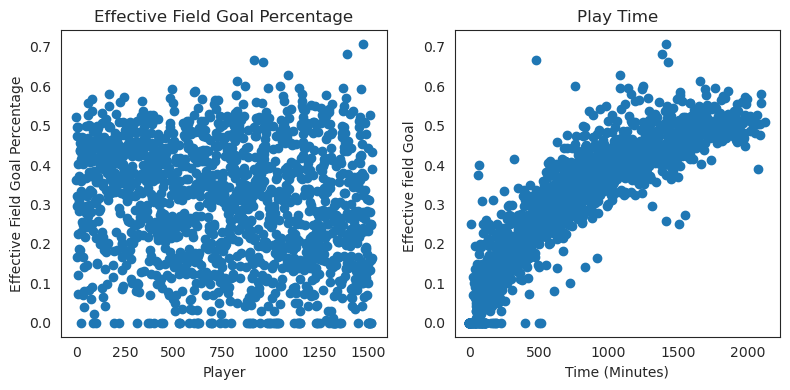

In [14]:
fig, ax = plt.subplots(1,2, figsize=(8, 4), dpi=100)

# Effective Field Goal Percentage
ax[0].scatter(box23_24_player.index, box23_24_player['effectiveFieldGoalPercentage'])
ax[0].set_title('Effective Field Goal Percentage')
ax[0].set_xlabel('Player')
ax[0].set_ylabel('Effective Field Goal Percentage')

# Play Time
ax[1].scatter( box23_24_player['minutes'],box23_24_player['effectiveFieldGoalPercentage'])
ax[1].set_title('Play Time vs Effective Field Goal Percentage')
ax[1].set_ylabel('Effective field Goal ')
ax[1].set_xlabel('Time (Minutes)')

plt.tight_layout()
plt.show()

# Cluster Shot selection

In [307]:
for prefix in season_prefixs:
    results_id = season_cluster_dict[prefix][['personId','cluster']]
    cluster_shots = results_id.merge(season_shot_dict[prefix], left_on='personId', right_on= 'PLAYER_ID',how = 'outer')
    cluster_shots.dropna(inplace = True)
    cluster_index = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13] 
    from matplotlib.colors import Normalize
    fig, ax = plt.subplots(7, 2, figsize=(16, 32), dpi=100)
    ax = ax.flatten() 
    
    #set scale 
    global_min = np.inf
    global_max = -np.inf
    
    for cluster in cluster_index:
        shots = cluster_shots[cluster_shots['cluster'] == cluster]
        kde = sns.kdeplot(x=shots.LOC_X, y=shots.LOC_Y, fill=True)
        density = kde.collections[0].get_paths()[0].vertices
        global_min = min(global_min, np.min(density[:, 1]))
        global_max = max(global_max, np.max(density[:, 1]))
    
    plt.close()
    
    # Normalize colormap scale based on global density range
    norm = Normalize(vmin=global_min, vmax=global_max)
    
    for i, cluster in enumerate(cluster_index):
        shots = cluster_shots[cluster_shots['cluster'] == cluster]
        sp.shot_chart(shots.LOC_X, shots.LOC_Y, title=f"Cluster {cluster+1} Shot Selection", ax=ax[i], kind='kde', hue_norm =norm)
    
    plt.tight_layout()
    #plt.show()
    
    fig.savefig(f'{prefix} shot_charts.png', format='png')


<Figure size 640x480 with 0 Axes>

In [ ]:
season_cluster_dict['218']

In [74]:
id_cols = big_box[['personId',  'teamName', 'firstName', 'familyName', 'playerSlug']].drop_duplicates(subset='personId')
lookup = season_cluster_dict['218'][['personId','cluster']].merge(id_cols, on = 'personId',how= 'inner')

cluster_index = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13] 

group_names = {}
for c in cluster_index:
    group = lookup[lookup['cluster']== c]
    group_names[c] = group

In [75]:
group_names[2].sample(7)

personId  cluster   teamName firstName familyName       playerSlug
346  1627786.0        2  Grizzlies      Troy   Williams    troy-williams
452  1628970.0        2    Hornets     Miles    Bridges    miles-bridges
302  1626220.0        2       Jazz     Royce    O'Neale     royce-oneale
269  1626150.0        2  Grizzlies    Andrew   Harrison  andrew-harrison
197   203485.0        2      76ers   Lorenzo      Brown    lorenzo-brown
212   203518.0        2    Thunder      Alex    Abrines     alex-abrines
456  1628975.0        2  Grizzlies     Jevon     Carter     jevon-carter

# Cluster Thoughts   

### Cluster 1 
    reconizable players: Chris Paul 

### Cluster 2


### Cluster 3 
    reconizable players: James Harden, Kyrie Irving, Paul George, Stephen Curry, Kevin 	Durant,
    heavy hitters
### Cluster 4
    reconizable players: 

### Cluster 5


### Cluster 6


### Cluster 7


### Cluster 8


### Cluster 9


### Cluster 10
    low playing time 
    

### Cluster 11


### Cluster 12


### Cluster 13


### Cluster 14



In [210]:
results.groupby('cluster').mean(numeric_only=True).reset_index().drop('personId')

cluster      personId      minutes  offensiveRating  defensiveRating  netRating  assistPercentage  assistToTurnover  assistRatio  offensiveReboundPercentage  defensiveReboundPercentage  reboundPercentage  turnoverRatio  effectiveFieldGoalPercentage  trueShootingPercentage  usagePercentage        pace   pacePer40       PIE     speed  distance  reboundChancesOffensive  reboundChancesDefensive  reboundChancesTotal    touches  secondaryAssists  freeThrowAssists     passes   assists  contestedFieldGoalsMade  contestedFieldGoalsAttempted  contestedFieldGoalPercentage  uncontestedFieldGoalsMade  uncontestedFieldGoalsAttempted  uncontestedFieldGoalsPercentage  fieldGoalPercentage  defendedAtRimFieldGoalsMade  defendedAtRimFieldGoalsAttempted  defendedAtRimFieldGoalPercentage  fieldGoalsMade  fieldGoalsAttempted  fieldGoalsPercentage  threePointersMade  threePointersAttempted  threePointersPercentage  freeThrowsMade  freeThrowsAttempted  freeThrowsPercentage  reboundsOffensive  \
0         0  9.918953e+05  1303.356722       105.136035       107.676294  -2.540241          0.229806          1.894531    29.924240                    0.025360                    0.105783           0.065447       9.894895                      0.471506                0.495631         0.148537   96.143464   80.119516  0.082533  4.072412  1.651697                 1.438085                 4.019135             5.347095  43.082087          0.442387          0.390136  33.872146  3.865043                 1.101352                      2.371821                      0.366167                   1.776221                        4.022851                         0.385503             0.408999                     1.210835                          1.698768                          0.546575        2.901770             6.458342              0.409199           0.866142                2.378463                 0.263044        0.820711             1.072586              0.298898           0.596857   
1         1  1.413636e+06  1505.301381       110.483900       109.612497   0.870802          0.099785          0.854094    16.389365                    0.027747                    0.102268           0.065013       8.305456                      0.537156                0.558181         0.151910   97.485144   81.237573  0.071510  4.146244  1.905495                 1.787221                 4.550055             6.176819  33.758900          0.264947          0.158887  23.756240  1.883920                 1.155983                      2.294182                      0.402198                   2.416013                        5.466146                         0.408267             0.433903                     1.553860                          2.292134                          0.576889        3.613678             7.852343              0.434147           1.695358                4.382234                 0.351095        1.052142             1.339812              0.364350           0.725260   
2         2  1.162191e+06  2040.556002       115.501180       110.705991   4.795574          0.269856          2.647499    21.229976                    0.023398                    0.121194           0.073243       8.720755                      0.534592                0.581315         0.270701   98.030186   81.691872  0.137887  3.934402  2.429599                 2.133293                 6.672738             8.626887  71.423723          0.887104          0.581072  46.876364  6.159161                 3.417399                      6.850877                      0.472324                   4.849152                       10.422932                         0.454025             0.466288                     1.825466                          2.621702                          0.613596        8.370628            17.486719              0.466672           2.401980                6.337773                 0.347478        4.495653             5.404366              0.754523           0.808552   
3         3  1.512912e+06   803.764993      

In [211]:
results.columns

Index(['personId', 'cluster', 'minutes', 'offensiveRating', 'defensiveRating', 'netRating', 'assistPercentage', 'assistToTurnover', 'assistRatio', 'offensiveReboundPercentage', 'defensiveReboundPercentage', 'reboundPercentage', 'turnoverRatio', 'effectiveFieldGoalPercentage', 'trueShootingPercentage', 'usagePercentage', 'pace', 'pacePer40', 'PIE', 'speed', 'distance', 'reboundChancesOffensive', 'reboundChancesDefensive', 'reboundChancesTotal', 'touches', 'secondaryAssists', 'freeThrowAssists', 'passes', 'assists', 'contestedFieldGoalsMade', 'contestedFieldGoalsAttempted', 'contestedFieldGoalPercentage', 'uncontestedFieldGoalsMade', 'uncontestedFieldGoalsAttempted', 'uncontestedFieldGoalsPercentage', 'fieldGoalPercentage', 'defendedAtRimFieldGoalsMade', 'defendedAtRimFieldGoalsAttempted', 'defendedAtRimFieldGoalPercentage', 'fieldGoalsMade', 'fieldGoalsAttempted', 'fieldGoalsPercentage', 'threePointersMade', 'threePointersAttempted', 'threePointersPercentage', 'freeThrowsMade',
       '

In [88]:
# function to produce per season clustering 
def cluster4000plot(df,shot_df,s):

    n_clusters = 13
    #remove the fluf
    df.drop([ 'teamId', 'teamCity', 'teamName', 'teamTricode', 'teamSlug','firstName','possessions', #'gameId',
                                'familyName', 'nameI'],axis=1,inplace =True)
    df.drop(df.filter(like='estimated').columns, axis=1,inplace = True)

    #get players  
    player_set = set(df['personId'])

    #convert time to seconds 
    #https://stackoverflow.com/questions/63663747/pandas-convert-time-into-seconds-for-all-values-in-column
    df['minutes']=df['minutes'].apply(lambda x: float(x.split(':')[0])*60+float(x.split(':')[1]))

    #get season averages 
    df_player = df.groupby('personId').mean(numeric_only=True).reset_index()
    
    #add average play time and % starting 5 
    for player in player_set:
        try:
            avg_play_time = df[df['personId'] == player]['minutes'].sum() / len(df[df['personId'] == player]) /60 
        except:
            avg_play_time = 0
        df.loc[df['personId'] == player, 'min_per_game'] = avg_play_time
        try:
            starter_pct = sum(df[df['personId'] == player]['position'] != 'n') / len(df[df['personId'] == player])
        except:
            starter_pct = 0 
        df.loc[df['personId'] == player, 'pct_games_started'] = starter_pct

    ######adding player shot location data 

    shot_chart_num = shot_df.drop([
        'GRID_TYPE', 'GAME_ID', 'GAME_EVENT_ID', 'PLAYER_NAME', 'TEAM_ID', 'TEAM_NAME',
        'PERIOD', 'ACTION_TYPE', 'SHOT_TYPE', 'MINUTES_REMAINING', 'EVENT_TYPE',
        'SECONDS_REMAINING', 'GAME_DATE', 'HTM', 'VTM', 'LOC_X', 'LOC_Y', 'SHOT_DISTANCE'
    ], axis=1)

    player_shot_summaries = pd.DataFrame()

    # calculate shooting stats for different zones
    for player_id, player_df in shot_chart_num.groupby('PLAYER_ID'):
       
        zone_summary = player_df.groupby(['SHOT_ZONE_BASIC']).agg(
            shot_attempts=('SHOT_ATTEMPTED_FLAG', 'size'),
            made_shots=('SHOT_MADE_FLAG', 'sum')
        ).reset_index()
    
        zone_summary['shooting_frequency'] = zone_summary['shot_attempts'] / zone_summary['shot_attempts'].sum()
        zone_summary['shooting_percentage'] = zone_summary['made_shots'] / zone_summary['shot_attempts']
    
        # Add player ID and clean up columns
        zone_summary['PLAYER_ID'] = player_id
        zone_summary['Location'] = zone_summary['SHOT_ZONE_BASIC']
        zone_summary = zone_summary.drop(['shot_attempts', 'made_shots', 'SHOT_ZONE_BASIC'], axis=1)
    
        # Pivot and flatten columns
        pivot_table = zone_summary.pivot_table(
            index='PLAYER_ID',
            columns='Location',
            values=['shooting_frequency', 'shooting_percentage'],
            aggfunc='first'
        )
        pivot_table.columns = [f'{stat}_{location}'.replace(' ', '_') for stat, location in pivot_table.columns]
        pivot_table.reset_index(inplace=True)
    
    
        player_shot_summaries = pd.concat([player_shot_summaries, pivot_table], ignore_index=True)
    
    # Merge with the box23_24_player DataFrame
    df_player_shots = df_player.merge(player_shot_summaries, left_on='personId', right_on='PLAYER_ID', how='outer',suffixes=('', '_y'))

    # Fill NaN values with 0 for people with no shots or missing shot positions
    df_player_shots = df_player_shots.fillna(0)

    #data's ready drop the ID's and scale
    to_cluster = df_player_shots.drop(['PLAYER_ID','personId'],axis = 1)

    scaled_box = RobustScaler().fit_transform(to_cluster)
    #input
    X = scaled_box
    range_n_clusters = range(14,15)
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (13 + 1) * 10])
    clusterer = KMeans(n_clusters=14, random_state=42, n_init=100, init='k-means++')
    cluster_labels = clusterer.fit_predict(X)
    results = pd.DataFrame(df_player['personId'])
    results['cluster'] = cluster_labels

    results_id = results[['personId','cluster']]
    cluster_shots = results_id.merge(df_player_shots, on='personId', how='outer')
    cluster_shots.drop(['PLAYER_ID'], inplace = True,axis = 1)

    labels = clusterer.labels_
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        f'season {s}',
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        round(silhouette_avg,5),
        "caliniski harabasz score",
        round(metrics.calinski_harabasz_score(X, labels),2)
    )
# Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )


    fig.savefig(f'{s} silhoette score.pmg',format = 'png')
    return cluster_shots